# Datos de los ligandos

## Obtención de los datos de los ligandos  cocristalizados con CDK2 desde Pubchem y Chembl

**Esta libreta tiene como objetivo extraer datos de las moléculas cocristalizadas con la proteína CDK2 a partir de las bases de datos CheMBL y PubChem**

> Puntos clave de esta libreta:
- Se extrae de la tabla de datos principal de la proteína las conformaciones que poseen a algún ligando en el sitio activo.
- Se crea un set de moléculas usando identificador PDB de cada molécula (cada molécula es designada con un id de 3 letras).
- Se usa el id de cada molécula (LIG) para obtener los datos de la página `http://www.rcsb.org/ligand/LIG`, correspondiente a cada ligando. Con ello obtenemos:
    - El smile isomérico de la molécula.
    - El InChI
    - El InChI Key
- Usamos el **InChI** para obtener los datos de cada molécula desde _**PUBCHEM**_ y _**CHEMBL**_.
- Guardamos los datos en un diccionario y a su vez lo exportamos a un archivo pinckle.

### Importamos algunas librerías iniciales

In [1]:
import pandas as pd
import numpy as np
import glob, os, sys
# Añadimos la ruta del directorio raíz para tener acceso a los archivos y módulos
sys.path.append(r'..')

## Cargamos los datos de la tabla principal

Nombre de la proteína:

In [2]:
# Nombre de la proteina de interes
prot_name = 'cdk2'

Cargamos el dataframe principal de la proteína:

In [3]:
# Este es el DF que no tiene aun afgregados los valores AUC de las conformaciones
patho_to_json_file = glob.glob((os.path.join('..', 'data', 
                        F'TABLA_MTDATA_{prot_name.upper()}_*_crys_LIGS_INFO.json')))[0]
                      
df_prot_labels = pd.read_json(patho_to_json_file)
df_prot_labels.shape

(402, 14)

**Esta tabla contiene ya la información de la molécula presente en el sitio activo de cada conformación de la proteína**

In [4]:
df_prot_labels.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.0,298,92.953020,2,"[9, 14]","[[36, 44], [149, 162]]",1,[STU],STU,440.0
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.0,298,97.315436,1,[9],"[[36, 44]]",3,"[ACE, ATP, MG]",ATP,398.0
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.1,298,97.315436,1,[9],"[[36, 44]]",3,"[ACE, ATP, MG]",ATP,398.0


## Identificación de los inhibidores
### Seleccionamos las conformaciones que posean algun inhibidor

In [5]:
filtro_inh = df_prot_labels.Inhib.notnull()
df_ligs_crys = df_prot_labels[filtro_inh]

In [6]:
# Número total de conformaciones con algún ligando en el sitio activo
df_ligs_crys.shape

(365, 14)

### Identificamos el número de ligandos únicos

In [7]:
ligs_crys_prot = set(df_ligs_crys.Inhib)
len(ligs_crys_prot)

315

## Comenzamos la obtención de los datos
El proceso es el siguiente:
> 1. Con el identificador de la molécula del PDB (nombe de tres letras, por ejemplo: ATP) se busca en el PDB la información de dicha molécula: http://www.rcsb.org/ligand
2. Se obtiene el *chemicalInChIKey*, el *chemicalInChI* y el SMILES isomérico de la molécula.
3. El *InChI el *InChIKey* o en su defecto el SMILES isimérico, es usado para buscar a la molécula en las bases de datos PubChem y Chembl.
    - Dichos *request* a la la API de cada base de datos se hacen con las librerías **_chembl_webresource_client_** y **_pubchemy_**.
4. Todos los datos disponibles de las moléculas son guardados en un diccionario de pyhton.
5. Finalmente el objeto se guarda en un archivo para posteriormente poder tener acceso al mismo.


### Web scrapping de los ligandos

In [8]:
# Librerías útiles para el web scrapping de los ligandos
import urllib.request
from bs4 import BeautifulSoup
from chembl_webresource_client.new_client import new_client
import pubchempy

In [9]:
# Url para accesar a la información de los ligandos en el PDB
URL_PDB = 'http://www.rcsb.org/ligand'

### Obtenemos los datos de cada ligando y los guardamos en un diccionario

In [10]:
# Generamos un diccionario con los datos de la molécula
dic_ligs_crys_prot = {}

for ligando in ligs_crys_prot[:
    url_lig = F'{URL_PDB}/{ligando}'
    print(F'Procesando al ligando: {ligando}\n')
    
    # Extraemos los datos del html del ligando:
    lig_data = urllib.request.urlopen( url_lig ).read().decode()
    
    # Extraemos del bsoup los siguientes datos:
    # InChIKey
    soup = BeautifulSoup(lig_data)
    inchi_key = soup.find("tr", {"id": "chemicalInChIKey"})
    inchi_key_str = inchi_key.find('td').text
    
    # InChI
    inchi = soup.find("tr", {"id": "chemicalInChI"})
    inchi_str = inchi.find('td').text
    
    # isomeric SMILE (por si no se encuentra en la API de PbCh)
    smiles = soup.find("tr", {"id": "chemicalIsomeric"})
    smiles_str = smiles.find('td').text
    
    # Peso molecular
    mw = soup.find("tr", {"id": "chemicalMolecularWeight"})
    mw_str = mw.find('td').text
    
    # Con los datos anteriores usamos la librería para accesar al Chembl
    # **** CHEMBL ****
    # Procedemos a extraer los datos del Chembl
    molecule = new_client.molecule
    try:
        chblMol_info = molecule.get(inchi_key_str)
        chembl_id = chblMol_info['molecule_chembl_id']
    except:
        print(F'No se pudo obtener infor de CEHMBL: {ligando}')
        print(inchi_str + '\n')
        chblMol_info = None
        chembl_id = None
        
    # Ahora obtenemos datos correspondientes a pubchem
    # *** PUBCHEM ***
    try:
        pbch_mol = pubchempy.get_compounds(inchi_str, 'inchi')[0]
        pbch_cid = pbch_mol.cid
        pbch_data = pbch_mol.to_dict()
        canonical_smiles = pbch_mol.canonical_smiles
    except:
        print(F'Fallo con datos PUBCHEM: {ligando}')
        pbch_mol = None
        pbch_cid = None
        pbch_data = None
        canonical_smiles = None
    # Creamos la entrada para el diccionario
    # Primero el diccionario del ligando
    dic_lig = {'inchi_key': inchi_key_str,
               'inchi': inchi_str,
               'molecular_weight': float(mw_str),
               'canonical_smiles': canonical_smiles,
               'isomeric_similes': smiles_str,
               'chembl_id': chembl_id,
               'chembl_data': chblMol_info,
               'pubchem_id': pbch_cid,
               'pubchem_data': pbch_data,}
    
    # Anidamos el dict  del ligando al dic principal
    dic_ligs_crys_prot[ligando] = dic_lig

## Guardamos el set de datos en formato *pickle*

In [11]:
import pickle

In [12]:
nombre_archivo = os.path.join('..','data', 'LIGS_CDK2_crys_pubchem_chembl_data.pkl')
if not os.path.exists(nombre_archivo):
    with open(nombre_archivo, 'wb') as dic_file:
        pickle.dump(dic_ligs_crys_prot, dic_file, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("El archivo ya ha sido creado.")

### Lectura del del archivo guardado

In [13]:
# Lectura del diccionario con pickle
nombre_archivo = os.path.join('..','data', 'LIGS_CDK2_crys_pubchem_chembl_data.pkl')
with open(nombre_archivo, 'rb') as dic_file:
    dic_ligs_crys_prot = pickle.load(open(nombre_archivo, 'rb'))

# Finalmente:
## Uso del diccionario final
A modo de ejemplo visualizamos algunos de los datos disponibles en el diccionario:

In [14]:
import rdkit as rd

RDKit WARNING: [16:53:39] Enabling RDKit 2019.09.1 jupyter extensions


ID Chembl: CHEMBL14249
cid Pubchem: 5957
Nombre: ADENOSINE TRIPHOSPHATE


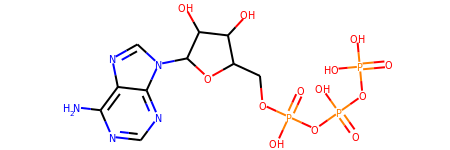

In [15]:
# Obtención del un ligando a través de una conformación
lig_1aq1 = df_ligs_crys.loc['1fin', 'Inhib']
# Imprimimos su nombre y otros datos interesantes
lig_1aq1_data = dic_ligs_crys_prot[lig_1aq1]
print(F'ID Chembl: {lig_1aq1_data["chembl_id"]}')
print(F'cid Pubchem: {lig_1aq1_data["pubchem_id"]}')
print(F'Nombre: {lig_1aq1_data["chembl_data"]["pref_name"]}')
# Obtenemos el smiles canonico
lig_1aq1_smiles = dic_ligs_crys_prot[lig_1aq1]['canonical_smiles']
# Lo visualizamos con rdkit
rd.Chem.MolFromSmiles(lig_1aq1_smiles)

ID Chembl: CHEMBL388978
Cid Pubchem: 44259
Nombre: STAUROSPORINE


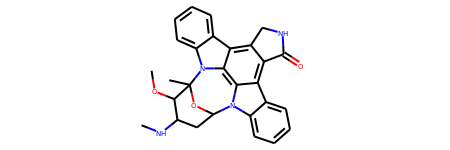

In [16]:
# Obtención del un ligando a través de una conformación
lig_1aq1 = df_ligs_crys.loc['1aq1', 'Inhib']
# Imprimimos su nombre y otros datos interesantes
lig_1aq1_data = dic_ligs_crys_prot[lig_1aq1]
print(F'ID Chembl: {lig_1aq1_data["chembl_id"]}')
print(F'Cid Pubchem: {lig_1aq1_data["pubchem_id"]}')
print(F'Nombre: {lig_1aq1_data["chembl_data"]["pref_name"]}')
# Obtenemos el smiles canonico
lig_1aq1_smiles = dic_ligs_crys_prot[lig_1aq1]['canonical_smiles']
# Lo visualizamos con rdkit
rd.Chem.MolFromSmiles(lig_1aq1_smiles)

# ¡Terminado!